In [2]:
import sys
import yfinance as yf
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional,BatchNormalization
from tensorflow.keras.optimizers import SGD
from tensorflow.random import set_seed
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tslearn.clustering import TimeSeriesKMeans
from sklearn.model_selection import train_test_split
import seaborn as sns
import utils
from importlib import reload
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
from datetime import datetime



2023-09-16 14:17:09.934179: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-16 14:17:12.685078: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f3ee7dbab00>
Traceback (most recent call last):
  File "/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, 

In [3]:
print("HELLOAS")
# feature_list = ['PctChgClCl']
feature_list = ['PctChgClCl','sumPctChgClCl_2','sumPctChgClCl_3','sumPctChgClCl_4','sumPctChgClCl_5','sumPctChgClCl_6','Close']
n_steps = 5

features = len(feature_list)
run_name = datetime.today().strftime('%Y-%m-%d_%H-%M')
run_number = 0
tstart = 2010
tend = 2020

# tickerList = ['aapl','spy','amd','qqq','amzn','meta','msft','f']
# tickerList = ['aapl','spy','amd','qqq']
tickerList = ['aapl']

trend_features = ['Close','Volume']
# pctChg_features = [f for f in feature_list if f not in trend_features]
# cluster_features = ['PctChgClCl','sumPctChgClCl_2','sumPctChgClCl_3','sumPctChgClCl_4','sumPctChgClCl_5','sumPctChgClCl_6']
# cluster_features = ['PctChgClCl']
# print("HELLOAS")
predictive_features = ['PctChgClCl','sumPctChgClCl_2','sumPctChgClCl_3','sumPctChgClCl_4','sumPctChgClCl_5','sumPctChgClCl_6']

remaining_features = [f for f in feature_list if f not in predictive_features and f not in trend_features]


HELLOAS


In [17]:
from sklearn.base import BaseEstimator, TransformerMixin
class CustomScaler(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.max_abs_trimmed_ = None
    
    def fit(self, X, y=None):
        # Assuming X is a DataFrame
        low, high = np.percentile(X, [5, 95], axis=0)  # axis=0 computes percentiles column-wise
        self.max_abs_trimmed_ = np.maximum(np.abs(low), np.abs(high))
        return self

    def transform(self, X):
        # Clip data column-wise
        X = np.clip(X, -self.max_abs_trimmed_, self.max_abs_trimmed_)

        # Scale values between -1 and 1 for each column, maintaining zero
        pos_mask = X > 0
        neg_mask = X < 0
        
        X[pos_mask] = X[pos_mask] / self.max_abs_trimmed_
        X[neg_mask] = X[neg_mask] / self.max_abs_trimmed_

        return X
    
    def inverse_transform(self, X):
        # Ensure we're working with a numpy array
        if isinstance(X, pd.DataFrame):
            X = X.values  # Convert to NumPy array

        X = X * self.max_abs_trimmed_

        return X


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
            PctChgClCl  sumPctChgClCl_2  sumPctChgClCl_3  sumPctChgClCl_4  \
Date                                                                        
2010-01-04    1.556498         1.126525         2.341251         1.155105   
2010-01-05    0.172893         1.729391         1.299419         2.514144   
2010-01-06   -1.590632        -1.417739         0.138759        -0.291214   
2010-01-07   -0.184871        -1.775503        -1.602610        -0.046112   
2010-01-08    0.664833         0.479962        -1.110670        -0.937777   

            sumPctChgClCl_5  sumPctChgClCl_6  
Date                                          
2010-01-04         2.384537         5.818480  
2010-01-05         1.327998         2.557430  
2010-01-06         0.923512        -0.262634  
2010-01-07        -0.476085         0.738641  
2010-01-08         0.618721         0.18

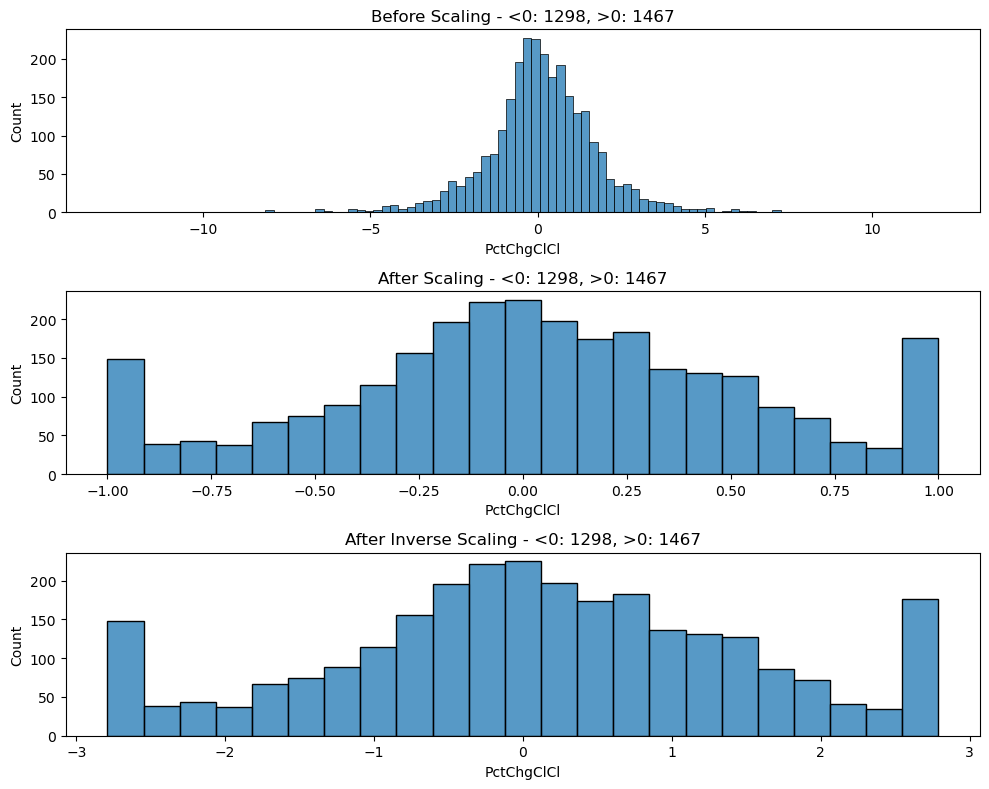

In [21]:
reload(utils)

# Initialize arrays as empty arrays with the necessary number of dimensions
X_train, X_test = np.empty((0, n_steps, len(feature_list))), np.empty((0, n_steps, len(feature_list)))
y_train, y_test = np.empty((0, 6)), np.empty((0, 6))

ticker = tickerList[0]

df = utils.prepareStockDf(ticker,tstart)
training_set, test_set = utils.train_test_split(df,tstart, tend, feature_list)

trim_columns = predictive_features
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 8))

# Before scaling
less_than_zero_before = np.sum(training_set['PctChgClCl'] < 0)
greater_than_zero_before = np.sum(training_set['PctChgClCl'] > 0)

sns.histplot(training_set['PctChgClCl'], ax=axes[0])
axes[0].set_title(f"Before Scaling - <0: {less_than_zero_before}, >0: {greater_than_zero_before}")

# Create and fit the scaler
scaler = CustomScaler()
scaler.fit(training_set[predictive_features])

# Transform the data
training_set[predictive_features] = scaler.transform(training_set[predictive_features])

# After scaling
less_than_zero_after = np.sum(training_set['PctChgClCl'] < 0)
greater_than_zero_after = np.sum(training_set['PctChgClCl'] > 0)

sns.histplot(training_set['PctChgClCl'], ax=axes[1])
axes[1].set_title(f"After Scaling - <0: {less_than_zero_after}, >0: {greater_than_zero_after}")

training_set[predictive_features] = scaler.inverse_transform(training_set[predictive_features])
less_than_zero_after = np.sum(training_set['PctChgClCl'] < 0)
greater_than_zero_after = np.sum(training_set['PctChgClCl'] > 0)
print(training_set[predictive_features].head())
sns.histplot(training_set['PctChgClCl'], ax=axes[2])
axes[2].set_title(f"After Inverse Scaling - <0: {less_than_zero_before}, >0: {greater_than_zero_before}")
# Show the plots
plt.tight_layout()
plt.show()

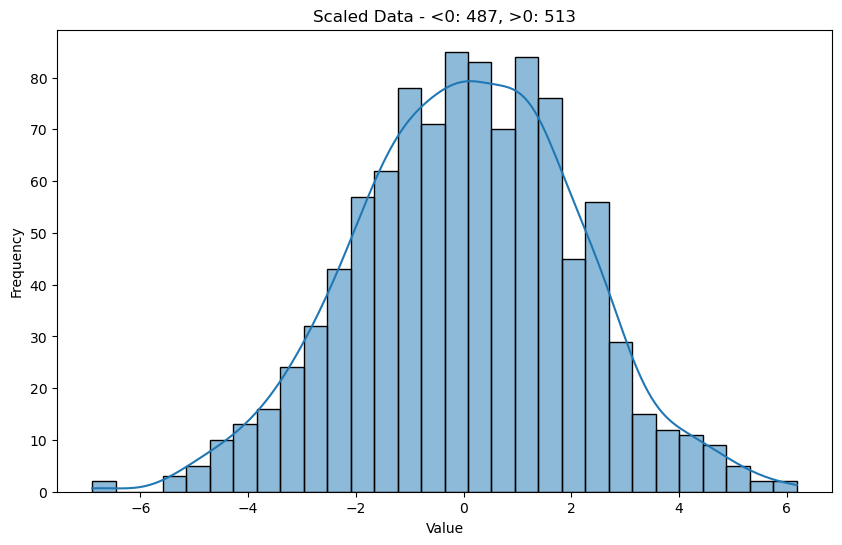

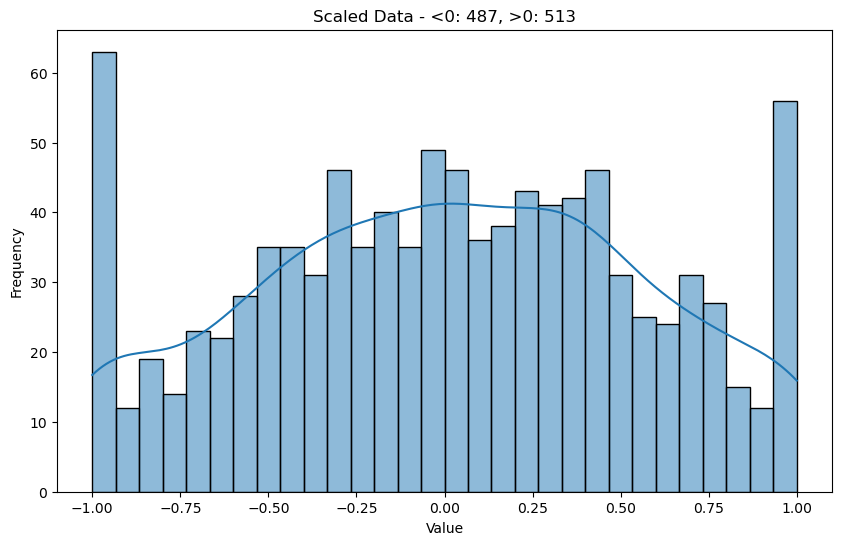

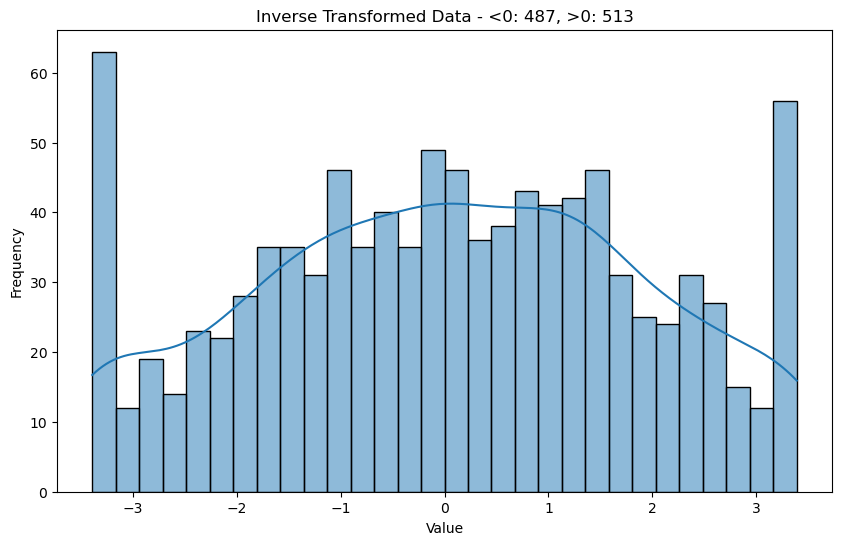

In [29]:
n_rows = 1000
n_features = 1

# Generate normally distributed random data that simulates daily percent changes
# A mean of 0 and standard deviation of 2% is just for this example.
fake_data = np.random.normal(loc=0, scale=2, size=(n_rows, n_features))

less_than_zero_scaled = np.sum(fake_data < 0)
greater_than_zero_scaled = np.sum(fake_data > 0)

# Plotting the scaled data
plt.figure(figsize=(10, 6))
sns.histplot(fake_data.flatten(), bins=30, kde=True)
plt.title(f"Scaled Data - <0: {less_than_zero_scaled}, >0: {greater_than_zero_scaled}")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()


# Create and fit the scaler
scaler = CustomScaler()
scaler.fit(fake_data)

# Scale the data
scaled_data = scaler.transform(fake_data)

# Compute the sums for scaled data
less_than_zero_scaled = np.sum(scaled_data < 0)
greater_than_zero_scaled = np.sum(scaled_data > 0)

# Plotting the scaled data
plt.figure(figsize=(10, 6))
sns.histplot(scaled_data.flatten(), bins=30, kde=True)
plt.title(f"Scaled Data - <0: {less_than_zero_scaled}, >0: {greater_than_zero_scaled}")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

# Inverse transform the scaled data
inverse_transformed_data = scaler.inverse_transform(scaled_data)

# Compute the sums for inverse transformed data
less_than_zero_inv = np.sum(inverse_transformed_data < 0)
greater_than_zero_inv = np.sum(inverse_transformed_data > 0)

# Plotting the inverse transformed data
plt.figure(figsize=(10, 6))
sns.histplot(inverse_transformed_data.flatten(), bins=30, kde=True)
plt.title(f"Inverse Transformed Data - <0: {less_than_zero_inv}, >0: {greater_than_zero_inv}")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()




In [88]:

trend_feature_index = [feature_list.index(trend) for trend in trend_features]

X_train = utils.scale_patterns(X_train,trend_feature_index)
display(X_train[0:1,:,-1])

array([[0.08242401, 0.15469748, 0.12146223, 0.07133437, 0.05161135,
        0.06137839, 0.14972323, 0.15736138, 0.04177883, 0.14946133,
        0.24028487, 0.16154432, 0.15887293, 0.341678  , 0.46456572,
        1.        , 0.90342959, 0.53659038, 0.58499531, 0.25355952,
        0.21912888, 0.16366572, 0.25875451, 0.32065857, 0.07209575,
        0.17539701, 0.        , 0.12025   , 0.19048439, 0.1158351 ]])

In [89]:
cluster_feature_index = [feature_list.index(cluster_feature) for cluster_feature in cluster_features]
X_cluster = utils.create_Cluster_Seq(X_train,cluster_feature_index)
display(X_cluster.shape)
display(X_cluster[0:1,:,-1])


(2734, 30, 6)

array([[ 1.        ,  0.45159157, -0.04637605,  0.13042934,  0.03332919,
        -0.04651592, -0.52222488, -0.30367866, -0.1250716 , -0.38752837,
         0.27623622,  0.16020662,  0.05582685, -1.        , -0.49174728,
         0.05291577, -0.56190238, -1.        , -1.        , -0.23384305,
        -0.60642305, -0.55215818, -1.        , -0.31167844,  0.20787658,
         0.15069407, -0.04807972, -0.03063738,  0.75772149,  0.71032267]])

In [90]:
import math
n_clusters = math.ceil(math.sqrt(len(X_cluster))) // 3
# A good rule of thumb is choosing k as the square root of the number of points in the training data set in kNN

km = TimeSeriesKMeans(n_clusters=n_clusters)

labels = km.fit_predict(X_cluster)

In [91]:
reload(utils)
threshold_factor = 1 # Adjust as necessary

X_cluster_adj, X_train_adj, y_train_adj, labels_adj = utils.remove_outliers(X_cluster,X_train,y_train,labels,km,threshold_factor)
display(X_cluster.shape)
display(X_train.shape)
display(y_train.shape)
display(X_cluster_adj.shape)
display(X_train_adj.shape)
display(y_train_adj.shape)
display(labels_adj.shape)

(2734, 30, 6)

(2734, 30, 20)

(2734, 6)

(2265, 30, 6)

(2265, 30, 20)

(2265, 6)

(2265,)

In [92]:
reload(utils)
utils.visualizeData(labels_adj,X_cluster_adj)


In [82]:
# cluster_assignments = km.predict(X_test)
# set(cluster_assignments)

In [93]:
import pickle 
visualDict = {'labels': labels_adj, 'X_train':X_cluster_adj}
pickle_name = os.path.join(run_path, "X_train.pkl")

with open(pickle_name, 'wb') as file:
    pickle.dump(visualDict,file)

In [94]:
if len(y_train.shape) == 1:
    df = pd.DataFrame({'label': labels_adj, 'target': y_train_adj})
else:
    # Convert the 2D y_train into a DataFrame
    y_df = pd.DataFrame(y_train_adj, columns=[f'target_{i}' for i in range(y_train_adj.shape[1])])
    df = pd.concat([pd.DataFrame({'label': labels_adj}), y_df], axis=1)

df.head()
display(df['label'].value_counts())


42    92
19    91
3     78
22    75
6     64
20    63
1     61
52    59
8     57
32    56
26    53
0     51
14    50
30    50
46    49
50    49
36    49
38    49
45    48
5     45
15    45
2     45
23    44
44    43
49    42
37    42
31    41
34    41
11    38
27    38
39    37
29    37
7     34
21    34
24    33
51    33
16    32
17    32
41    32
13    31
43    31
48    30
47    29
33    29
35    28
40    28
18    26
12    25
4     25
25    21
10    21
28    17
9     12
Name: label, dtype: int64

In [63]:
# display(X_train.shape)
# display(y_train.mean())
# display(cluster_X_train[0])

# label_filter = 1
# filtered_x_train, filtered_y_train = utils.filter_clusters(labels,label_filter,X_train_scaled,y_train_scaled)
# filtered_x_train.shape

In [64]:
def create_model():
    model_lstm = Sequential()

    # Using Bidirectional LSTM for the first layer
    model_lstm.add(Bidirectional(LSTM(units=100, activation='tanh', return_sequences=True), input_shape=(None, features)))
    model_lstm.add(BatchNormalization())  # Batch normalization
    model_lstm.add(Dropout(0.2))

    model_lstm.add(LSTM(units=250, activation='tanh', return_sequences=True))  # Changed number of units to 250
    model_lstm.add(BatchNormalization())  # Batch normalization
    model_lstm.add(Dropout(0.2))

    model_lstm.add(LSTM(units=250, activation='tanh', return_sequences=True))  # Changed number of units to 250
    model_lstm.add(BatchNormalization())  # Batch normalization
    model_lstm.add(Dropout(0.2))

    model_lstm.add(GRU(units=250, activation='tanh', return_sequences=True))  # Changed number of units to 250
    model_lstm.add(BatchNormalization())  # Batch normalization
    model_lstm.add(Dropout(0.2))

    model_lstm.add(GRU(units=100, activation='tanh', return_sequences=True))  # Changed number of units to 250
    model_lstm.add(BatchNormalization())  # Batch normalization
    model_lstm.add(Dropout(0.2))

    model_lstm.add(LSTM(units=100, activation='tanh'))  # Changed number of units to 100
    model_lstm.add(BatchNormalization())  # Batch normalization
    model_lstm.add(Dropout(0.2))

    model_lstm.add(Dense(units=6))

    # Using Adam optimizer with a learning rate scheduler
    optimizer = Adam(learning_rate=0.001)
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1, min_lr=1e-5)

    model_lstm.compile(optimizer=optimizer, loss="mse")
    return model_lstm







In [65]:

for lab in set(labels_adj): 
    filtered_x_train, filtered_y_train = utils.filter_clusters(labels_adj, lab, X_train_adj, y_train_adj)

    X_test = utils.scale_patterns(X_test,trend_feature_index)
    # display(X_train[0:1,:,-1])
    X_cluster_test = utils.create_Cluster_Seq(X_test,cluster_feature_index)
    # display(X_cluster_test.shape)

    cluster_assignments = km.predict(X_cluster_test)

    # values, counts = np.unique(cluster_assignments, return_counts=True)

    # # Display the results
    # for value, count in zip(values, counts):
    #     print(f"Value: {value}, Count: {count}")

    X_cluster_test_adj,X_test_adj, y_test_adj, labels_test_adj = utils.remove_outliers(X_cluster_test,X_test,y_test,cluster_assignments,km,threshold_factor)

    filtered_x_test, filtered_y_test = utils.filter_clusters(labels_test_adj, lab, X_test_adj, y_test_adj)
    
    # display(X_cluster_test_adj.shape)
    # display(filtered_x_test.shape)
    # display(filtered_y_test.shape)

    if len(filtered_x_test) == 0:
        continue

    # display(filtered_x_train.shape)
    model_lstm = create_model()
    model_lstm.fit(filtered_x_train, filtered_y_train, batch_size=30, epochs=200, verbose=1)

    

    predicted_stock_price = model_lstm.predict(filtered_x_test)

    # Assuming predicted_stock_price has two columns
    results = pd.DataFrame({
        'predicted_1': predicted_stock_price[:, 0],
        'predicted_2': predicted_stock_price[:, 1],
        'predicted_3': predicted_stock_price[:, 2],
        'predicted_4': predicted_stock_price[:, 3],
        'predicted_5': predicted_stock_price[:, 4],
        'predicted_6': predicted_stock_price[:, 5],
        'real_1': filtered_y_test[:, 0],
        'real_2': filtered_y_test[:, 1],
        'real_3': filtered_y_test[:, 2],
        'real_4': filtered_y_test[:, 3],
        'real_5': filtered_y_test[:, 4],
        'real_6': filtered_y_test[:, 5]
    })

    # Assuming a correct prediction means both predicted features have the same sign as their corresponding real values
    results['same_1'] = ((results['predicted_1'] > 0) & (results['real_1'] > 0)) | ((results['predicted_1'] < 0) & (results['real_1'] < 0))
    results['same_2'] = ((results['predicted_2'] > 0) & (results['real_2'] > 0)) | ((results['predicted_2'] < 0) & (results['real_2'] < 0))
    results['same_3'] = ((results['predicted_3'] > 0) & (results['real_3'] > 0)) | ((results['predicted_3'] < 0) & (results['real_3'] < 0))
    results['same_4'] = ((results['predicted_4'] > 0) & (results['real_4'] > 0)) | ((results['predicted_4'] < 0) & (results['real_4'] < 0))
    results['same_5'] = ((results['predicted_5'] > 0) & (results['real_5'] > 0)) | ((results['predicted_5'] < 0) & (results['real_5'] < 0))
    results['same_6'] = ((results['predicted_6'] > 0) & (results['real_6'] > 0)) | ((results['predicted_6'] < 0) & (results['real_6'] < 0))
    accuracy1 = results['same_1'].sum() / len(results) * 100
    accuracy2 = results['same_2'].sum() / len(results) * 100
    accuracy3 = results['same_3'].sum() / len(results) * 100
    accuracy4 = results['same_4'].sum() / len(results) * 100
    accuracy5 = results['same_5'].sum() / len(results) * 100
    accuracy6 = results['same_6'].sum() / len(results) * 100

    # Construct the string
    output_string = (
        "Cluster Number: " + str(lab) +
        " \nAccuracy1D " + str(accuracy1) + " PredictedRet: " + str(results['predicted_1'].mean()) + " ActRet " + str(results['real_1'].mean() ) +
        " \nAccuracy2D " + str(accuracy2) + " PredictedRet: " + str(results['predicted_2'].mean()) + " ActRet " + str(results['real_2'].mean() ) +
        " \nAccuracy3D " + str(accuracy3) + " PredictedRet: " + str(results['predicted_3'].mean()) + " ActRet " + str(results['real_3'].mean() ) +
        " \nAccuracy4D " + str(accuracy4) + " PredictedRet: " + str(results['predicted_4'].mean()) + " ActRet " + str(results['real_4'].mean() ) +
        " \nAccuracy5D " + str(accuracy5) + " PredictedRet: " + str(results['predicted_5'].mean()) + " ActRet " + str(results['real_5'].mean() ) +
        " \nAccuracy6D " + str(accuracy6) + " PredictedRet: " + str(results['predicted_6'].mean()) + " ActRet " + str(results['real_6'].mean() ) +
        " Test set length: " + str(len(filtered_y_test)) + "\n"
    )

    # Write the string to a file
    with open(file_name, 'a') as f:
        f.write(output_string)






2023-09-15 18:00:51.847153: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-09-15 18:00:51.847187: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: acet116-lnx-12
2023-09-15 18:00:51.847191: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: acet116-lnx-12
2023-09-15 18:00:51.847258: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 535.98.0
2023-09-15 18:00:51.847271: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 535.98.0
2023-09-15 18:00:51.847275: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:309] kernel version seems to match DSO: 535.98.0
2023-09-15 18:00:52.018019: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor 

Epoch 1/50


2023-09-15 18:00:53.058472: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-15 18:00:53.059514: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-15 18:00:53.060264: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

3/3 [==============================] - 7s 23ms/step - loss: 2.8202
Epoch 2/50
3/3 [==============================] - 0s 22ms/step - loss: 1.8385
Epoch 3/50
3/3 [==============================] - 0s 21ms/step - loss: 1.4076
Epoch 4/50
3/3 [==============================] - 0s 21ms/step - loss: 1.4445
Epoch 5/50
3/3 [==============================] - 0s 22ms/step - loss: 1.1727
Epoch 6/50
3/3 [==============================] - 0s 21ms/step - loss: 1.0453
Epoch 7/50
3/3 [==============================] - 0s 22ms/step - loss: 1.0194
Epoch 8/50
3/3 [==============================] - 0s 22ms/step - loss: 1.0283
Epoch 9/50
3/3 [==============================] - 0s 21ms/step - loss: 0.7667
Epoch 10/50
3/3 [==============================] - 0s 22ms/step - loss: 0.9235
Epoch 11/50
3/3 [==============================] - 0s 22ms/step - loss: 0.8412
Epoch 12/50
3/3 [==============================] - 0s 21ms/step - loss: 0.9874
Epoch 13/50
3/3 [==============================] - 0s 22ms/step - loss: 

2023-09-15 18:01:03.392036: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-15 18:01:03.392959: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-15 18:01:03.393668: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 1s 5ms/step


2023-09-15 18:01:04.831438: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-15 18:01:04.832418: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-15 18:01:04.833132: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/50


2023-09-15 18:01:05.612043: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-15 18:01:05.613114: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-15 18:01:05.613823: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 7s 21ms/step - loss: 2.4990
Epoch 2/50
4/4 [==============================] - 0s 21ms/step - loss: 1.8323
Epoch 3/50
4/4 [==============================] - 0s 21ms/step - loss: 1.5359
Epoch 4/50
4/4 [==============================] - 0s 21ms/step - loss: 1.2153
Epoch 5/50
4/4 [==============================] - 0s 21ms/step - loss: 1.3612
Epoch 6/50
4/4 [==============================] - 0s 21ms/step - loss: 1.1962
Epoch 7/50
4/4 [==============================] - 0s 21ms/step - loss: 1.0644
Epoch 8/50
4/4 [==============================] - 0s 21ms/step - loss: 1.0043
Epoch 9/50
4/4 [==============================] - 0s 22ms/step - loss: 1.0814
Epoch 10/50
4/4 [==============================] - 0s 21ms/step - loss: 0.9774
Epoch 11/50
4/4 [==============================] - 0s 21ms/step - loss: 0.9850
Epoch 12/50
4/4 [==============================] - 0s 21ms/step - loss: 0.9092
Epoch 13/50
4/4 [==============================] - 0s 22ms/step - loss: 

2023-09-15 18:01:17.284780: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-15 18:01:17.285525: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-15 18:01:17.286879: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 1s 4ms/step


2023-09-15 18:01:18.723812: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-15 18:01:18.724959: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-15 18:01:18.725629: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/50


2023-09-15 18:01:19.531740: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-15 18:01:19.532842: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-15 18:01:19.533520: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 7s 22ms/step - loss: 2.1615
Epoch 2/50
4/4 [==============================] - 0s 22ms/step - loss: 1.4501
Epoch 3/50
4/4 [==============================] - 0s 27ms/step - loss: 1.2419
Epoch 4/50
4/4 [==============================] - 0s 26ms/step - loss: 0.9985
Epoch 5/50
4/4 [==============================] - 0s 24ms/step - loss: 1.0275
Epoch 6/50
4/4 [==============================] - 0s 22ms/step - loss: 0.8031
Epoch 7/50
4/4 [==============================] - 0s 22ms/step - loss: 0.8305
Epoch 8/50
4/4 [==============================] - 0s 22ms/step - loss: 0.7615
Epoch 9/50
4/4 [==============================] - 0s 22ms/step - loss: 0.6858
Epoch 10/50
4/4 [==============================] - 0s 22ms/step - loss: 0.6968
Epoch 11/50
4/4 [==============================] - 0s 22ms/step - loss: 0.6348
Epoch 12/50
4/4 [==============================] - 0s 23ms/step - loss: 0.5819
Epoch 13/50
4/4 [==============================] - 0s 22ms/step - loss: 

2023-09-15 18:01:31.366808: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-15 18:01:31.367565: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-15 18:01:31.368364: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 1s 5ms/step


2023-09-15 18:01:32.831661: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-15 18:01:32.832463: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-15 18:01:32.833308: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/50


2023-09-15 18:01:33.617609: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-15 18:01:33.618796: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-15 18:01:33.619505: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

3/3 [==============================] - 7s 20ms/step - loss: 2.7473
Epoch 2/50
3/3 [==============================] - 0s 20ms/step - loss: 1.9090
Epoch 3/50
3/3 [==============================] - 0s 20ms/step - loss: 1.5408
Epoch 4/50
3/3 [==============================] - 0s 20ms/step - loss: 1.3158
Epoch 5/50
3/3 [==============================] - 0s 20ms/step - loss: 1.2503
Epoch 6/50
3/3 [==============================] - 0s 20ms/step - loss: 1.0747
Epoch 7/50
3/3 [==============================] - 0s 21ms/step - loss: 0.9445
Epoch 8/50
3/3 [==============================] - 0s 20ms/step - loss: 0.9481
Epoch 9/50
3/3 [==============================] - 0s 21ms/step - loss: 0.8579
Epoch 10/50
3/3 [==============================] - 0s 21ms/step - loss: 0.7897
Epoch 11/50
3/3 [==============================] - 0s 21ms/step - loss: 0.7558
Epoch 12/50
3/3 [==============================] - 0s 21ms/step - loss: 0.7790
Epoch 13/50
3/3 [==============================] - 0s 20ms/step - loss: 

2023-09-15 18:01:44.557325: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-15 18:01:44.558585: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-15 18:01:44.559370: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 1s 5ms/step


2023-09-15 18:01:46.144950: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-15 18:01:46.146101: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-15 18:01:46.146864: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/50


2023-09-15 18:01:46.943853: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-15 18:01:46.944959: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-15 18:01:46.945738: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

6/6 [==============================] - 7s 21ms/step - loss: 1.8541
Epoch 2/50
6/6 [==============================] - 0s 21ms/step - loss: 1.3125
Epoch 3/50
6/6 [==============================] - 0s 21ms/step - loss: 1.1227
Epoch 4/50
6/6 [==============================] - 0s 21ms/step - loss: 0.8903
Epoch 5/50
6/6 [==============================] - 0s 21ms/step - loss: 0.8412
Epoch 6/50
6/6 [==============================] - 0s 23ms/step - loss: 0.7422
Epoch 7/50
6/6 [==============================] - 0s 25ms/step - loss: 0.7580
Epoch 8/50
6/6 [==============================] - 0s 22ms/step - loss: 0.6527
Epoch 9/50
6/6 [==============================] - 0s 21ms/step - loss: 0.6183
Epoch 10/50
6/6 [==============================] - 0s 21ms/step - loss: 0.6281
Epoch 11/50
6/6 [==============================] - 0s 21ms/step - loss: 0.6174
Epoch 12/50
6/6 [==============================] - 0s 21ms/step - loss: 0.5612
Epoch 13/50
6/6 [==============================] - 0s 21ms/step - loss: 

2023-09-15 18:02:00.894627: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-15 18:02:00.895443: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-15 18:02:00.896214: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 1s 6ms/step


2023-09-15 18:02:02.328616: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-15 18:02:02.329770: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-15 18:02:02.330473: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/50


2023-09-15 18:02:03.117877: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-15 18:02:03.118753: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-15 18:02:03.119588: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

3/3 [==============================] - 7s 18ms/step - loss: 2.4531
Epoch 2/50
3/3 [==============================] - 0s 18ms/step - loss: 1.7952
Epoch 3/50
3/3 [==============================] - 0s 17ms/step - loss: 1.5656
Epoch 4/50
3/3 [==============================] - 0s 18ms/step - loss: 1.2780
Epoch 5/50
3/3 [==============================] - 0s 18ms/step - loss: 1.1529
Epoch 6/50
3/3 [==============================] - 0s 18ms/step - loss: 1.0587
Epoch 7/50
3/3 [==============================] - 0s 18ms/step - loss: 0.9728
Epoch 8/50
3/3 [==============================] - 0s 18ms/step - loss: 0.9294
Epoch 9/50
3/3 [==============================] - 0s 18ms/step - loss: 0.8696
Epoch 10/50
3/3 [==============================] - 0s 20ms/step - loss: 0.9423
Epoch 11/50
3/3 [==============================] - 0s 24ms/step - loss: 0.8789
Epoch 12/50
3/3 [==============================] - 0s 20ms/step - loss: 0.7811
Epoch 13/50
3/3 [==============================] - 0s 18ms/step - loss: 

2023-09-15 18:02:13.517833: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-15 18:02:13.518757: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-15 18:02:13.519489: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 1s 4ms/step


2023-09-15 18:02:15.004226: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-15 18:02:15.005315: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-15 18:02:15.006093: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/50


2023-09-15 18:02:15.768130: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-15 18:02:15.769213: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-15 18:02:15.769943: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

5/5 [==============================] - 7s 22ms/step - loss: 2.2276
Epoch 2/50
5/5 [==============================] - 0s 21ms/step - loss: 1.3953
Epoch 3/50
5/5 [==============================] - 0s 20ms/step - loss: 1.2529
Epoch 4/50
5/5 [==============================] - 0s 21ms/step - loss: 1.0352
Epoch 5/50
5/5 [==============================] - 0s 21ms/step - loss: 0.9817
Epoch 6/50
5/5 [==============================] - 0s 21ms/step - loss: 0.8572
Epoch 7/50
5/5 [==============================] - 0s 21ms/step - loss: 0.8824
Epoch 8/50
5/5 [==============================] - 0s 21ms/step - loss: 0.7812
Epoch 9/50
5/5 [==============================] - 0s 21ms/step - loss: 0.8271
Epoch 10/50
5/5 [==============================] - 0s 21ms/step - loss: 0.8067
Epoch 11/50
5/5 [==============================] - 0s 21ms/step - loss: 0.7888
Epoch 12/50
5/5 [==============================] - 0s 21ms/step - loss: 0.6899
Epoch 13/50
5/5 [==============================] - 0s 21ms/step - loss: 

2023-09-15 18:02:28.548283: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-15 18:02:28.549170: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-15 18:02:28.549854: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 1s 6ms/step


2023-09-15 18:02:29.999035: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-15 18:02:30.000032: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-15 18:02:30.000738: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/50


2023-09-15 18:02:30.763694: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-15 18:02:30.764850: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-15 18:02:30.765669: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

3/3 [==============================] - 7s 23ms/step - loss: 2.4117
Epoch 2/50
3/3 [==============================] - 0s 22ms/step - loss: 1.6485
Epoch 3/50
3/3 [==============================] - 0s 23ms/step - loss: 1.3407
Epoch 4/50
3/3 [==============================] - 0s 23ms/step - loss: 1.2083
Epoch 5/50
3/3 [==============================] - 0s 23ms/step - loss: 1.1209
Epoch 6/50
3/3 [==============================] - 0s 22ms/step - loss: 1.0593
Epoch 7/50
3/3 [==============================] - 0s 23ms/step - loss: 0.9647
Epoch 8/50
3/3 [==============================] - 0s 22ms/step - loss: 0.8950
Epoch 9/50
3/3 [==============================] - 0s 23ms/step - loss: 0.8058
Epoch 10/50
3/3 [==============================] - 0s 22ms/step - loss: 0.8482
Epoch 11/50
3/3 [==============================] - 0s 28ms/step - loss: 0.8181
Epoch 12/50
3/3 [==============================] - 0s 28ms/step - loss: 0.7824
Epoch 13/50
3/3 [==============================] - 0s 26ms/step - loss: 

2023-09-15 18:02:41.782481: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-15 18:02:41.783339: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-15 18:02:41.784011: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 1s 6ms/step


2023-09-15 18:02:43.231649: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-15 18:02:43.232783: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-15 18:02:43.233685: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/50


2023-09-15 18:02:44.030486: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-15 18:02:44.031385: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-15 18:02:44.032077: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

3/3 [==============================] - 7s 23ms/step - loss: 2.2861
Epoch 2/50
3/3 [==============================] - 0s 22ms/step - loss: 1.9890
Epoch 3/50
3/3 [==============================] - 0s 23ms/step - loss: 1.3975
Epoch 4/50
3/3 [==============================] - 0s 21ms/step - loss: 1.1979
Epoch 5/50
3/3 [==============================] - 0s 21ms/step - loss: 1.0802
Epoch 6/50
3/3 [==============================] - 0s 21ms/step - loss: 1.0240
Epoch 7/50
3/3 [==============================] - 0s 21ms/step - loss: 1.0495
Epoch 8/50
3/3 [==============================] - 0s 21ms/step - loss: 0.9404
Epoch 9/50
3/3 [==============================] - 0s 21ms/step - loss: 0.8740
Epoch 10/50
3/3 [==============================] - 0s 21ms/step - loss: 0.8673
Epoch 11/50
3/3 [==============================] - 0s 21ms/step - loss: 0.8456
Epoch 12/50
3/3 [==============================] - 0s 21ms/step - loss: 0.8186
Epoch 13/50
3/3 [==============================] - 0s 21ms/step - loss: 

2023-09-15 18:02:54.728868: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-15 18:02:54.730072: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-15 18:02:54.730890: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 2s 6ms/step


2023-09-15 18:02:56.240104: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-15 18:02:56.241192: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-15 18:02:56.242023: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/50


2023-09-15 18:02:57.023886: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-15 18:02:57.024868: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-15 18:02:57.025543: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

5/5 [==============================] - 7s 20ms/step - loss: 2.1456
Epoch 2/50
5/5 [==============================] - 0s 21ms/step - loss: 1.7258
Epoch 3/50
5/5 [==============================] - 0s 20ms/step - loss: 1.3239
Epoch 4/50
5/5 [==============================] - 0s 21ms/step - loss: 1.1514
Epoch 5/50
5/5 [==============================] - 0s 21ms/step - loss: 1.0626
Epoch 6/50
5/5 [==============================] - 0s 21ms/step - loss: 1.1121
Epoch 7/50
5/5 [==============================] - 0s 21ms/step - loss: 0.9536
Epoch 8/50
5/5 [==============================] - 0s 21ms/step - loss: 0.9759
Epoch 9/50
5/5 [==============================] - 0s 21ms/step - loss: 0.9050
Epoch 10/50
5/5 [==============================] - 0s 21ms/step - loss: 0.9485
Epoch 11/50
5/5 [==============================] - 0s 21ms/step - loss: 0.8998
Epoch 12/50
5/5 [==============================] - 0s 21ms/step - loss: 0.9109
Epoch 13/50
5/5 [==============================] - 0s 21ms/step - loss: 

2023-09-15 18:03:09.382291: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-15 18:03:09.383162: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-15 18:03:09.383845: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 1s 7ms/step


2023-09-15 18:03:11.297548: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-15 18:03:11.298676: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-15 18:03:11.299555: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/50


2023-09-15 18:03:12.099155: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-15 18:03:12.100231: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-15 18:03:12.100889: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

3/3 [==============================] - 7s 19ms/step - loss: 2.7462
Epoch 2/50
3/3 [==============================] - 0s 24ms/step - loss: 1.8052
Epoch 3/50
3/3 [==============================] - 0s 24ms/step - loss: 1.5843
Epoch 4/50
3/3 [==============================] - 0s 21ms/step - loss: 1.1653
Epoch 5/50
3/3 [==============================] - 0s 19ms/step - loss: 1.2205
Epoch 6/50
3/3 [==============================] - 0s 20ms/step - loss: 1.2285
Epoch 7/50
3/3 [==============================] - 0s 20ms/step - loss: 1.0119
Epoch 8/50
3/3 [==============================] - 0s 20ms/step - loss: 0.9140
Epoch 9/50
3/3 [==============================] - 0s 20ms/step - loss: 0.9945
Epoch 10/50
3/3 [==============================] - 0s 20ms/step - loss: 0.8148
Epoch 11/50
3/3 [==============================] - 0s 20ms/step - loss: 0.8563
Epoch 12/50
3/3 [==============================] - 0s 20ms/step - loss: 0.8930
Epoch 13/50
3/3 [==============================] - 0s 20ms/step - loss: 

2023-09-15 18:03:22.167974: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-15 18:03:22.169030: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-15 18:03:22.169896: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 1s 5ms/step


2023-09-15 18:03:23.632634: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-15 18:03:23.633761: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-15 18:03:23.634496: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/50


2023-09-15 18:03:24.399627: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-15 18:03:24.400514: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-15 18:03:24.401184: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 7s 23ms/step - loss: 2.5805
Epoch 2/50
2/2 [==============================] - 0s 23ms/step - loss: 2.0889
Epoch 3/50
2/2 [==============================] - 0s 28ms/step - loss: 1.7394
Epoch 4/50
2/2 [==============================] - 0s 24ms/step - loss: 1.4796
Epoch 5/50
2/2 [==============================] - 0s 24ms/step - loss: 1.4243
Epoch 6/50
2/2 [==============================] - 0s 23ms/step - loss: 1.1554
Epoch 7/50
2/2 [==============================] - 0s 25ms/step - loss: 1.1208
Epoch 8/50
2/2 [==============================] - 0s 24ms/step - loss: 1.0603
Epoch 9/50
2/2 [==============================] - 0s 23ms/step - loss: 1.0169
Epoch 10/50
2/2 [==============================] - 0s 23ms/step - loss: 0.8656
Epoch 11/50
2/2 [==============================] - 0s 24ms/step - loss: 0.7868
Epoch 12/50
2/2 [==============================] - 0s 23ms/step - loss: 0.7992
Epoch 13/50
2/2 [==============================] - 0s 24ms/step - loss: 

2023-09-15 18:03:34.246188: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-15 18:03:34.247204: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-15 18:03:34.247924: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 1s 1s/step


2023-09-15 18:03:35.722609: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-15 18:03:35.723531: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-15 18:03:35.724233: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/50


2023-09-15 18:03:36.493998: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-15 18:03:36.495039: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-15 18:03:36.495749: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 7s 21ms/step - loss: 2.2537
Epoch 2/50
4/4 [==============================] - 0s 21ms/step - loss: 1.7377
Epoch 3/50
4/4 [==============================] - 0s 20ms/step - loss: 1.3516
Epoch 4/50
4/4 [==============================] - 0s 21ms/step - loss: 1.2240
Epoch 5/50
4/4 [==============================] - 0s 21ms/step - loss: 1.0466
Epoch 6/50
4/4 [==============================] - 0s 21ms/step - loss: 0.9932
Epoch 7/50
4/4 [==============================] - 0s 21ms/step - loss: 0.8883
Epoch 8/50
4/4 [==============================] - 0s 22ms/step - loss: 0.8567
Epoch 9/50
4/4 [==============================] - 0s 22ms/step - loss: 0.9008
Epoch 10/50
4/4 [==============================] - 0s 22ms/step - loss: 0.8469
Epoch 11/50
4/4 [==============================] - 0s 21ms/step - loss: 0.7903
Epoch 12/50
4/4 [==============================] - 0s 21ms/step - loss: 0.7325
Epoch 13/50
4/4 [==============================] - 0s 21ms/step - loss: 

2023-09-15 18:03:48.428578: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-15 18:03:48.429492: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-15 18:03:48.430210: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 1s 5ms/step
